In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
knot_types = {
	'standard_14': 0,  # 1
	'standard_16': 1,  # 2
	'standard_18': 2,  # 3
	'30both': 3,  # 4
	'30oneZ': 4,  # 5
	'optimized': 5,  # 6
	'pm_03_z': 6,  # 7
	'4foil': 7,  # 8
	'6foil': 8,  # 9
	'stand4foil': 9,  # 10
	'30oneX': 10,  # 11

}

knots = [
	'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
	'optimized', 'pm_03_z', '4foil', '6foil', 'stand4foil',
	'30oneX'
]
knot_types = {
	'standard_14': 0,  # 1
	'standard_16': 1,  # 2
	'standard_18': 2,  # 3
	'30both': 3,  # 4
	'30oneZ': 4,  # 5
	'optimized': 5,  # 6
	'pm_03_z': 6,  # 7
	'30oneX': 7,  # 11

}
knots = [
	'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
	'optimized', 'pm_03_z',
	'30oneX'
]
folder = 'data_low_10'
desired_res = (16, 16, 16)

num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)
for knot in knots:
    filename = f'..\\{folder}\\data_{knot}.csv'
    with open(filename, 'r') as file:
        reader = csv.reader(file)

        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            data_array = np.array(data_list)
            points_list = data_array[2:]
            Nx, Ny, Nz = data_array[1]
            if desired_res != (Nx, Ny, Nz):
                scale_x = desired_res[0] / Nx
                scale_y = desired_res[1] / Ny
                scale_z = desired_res[2] / Nz
                points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            # Initialize a 3D array with zeros
            dots_3d = np.zeros(desired_res, dtype=int)
            # Set the specified coordinates to 1
            for x, y, z in points_list:
                try: dots_3d[x, y, z] = 1
                except IndexError: continue
            X_list.append(dots_3d)
            # X_list.append(data_array)
            Y_list.append(knot_types[knot])


In [5]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
# X_torch = torch.tensor(X_np).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)

torch.Size([10000, 1, 16, 16, 16]) torch.Size([10000, 10])


In [6]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_torch, y_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [7]:
def conv_stage(layer_configs):
    layers = []
    for config in layer_configs:
        in_channels, out_channels, kernel_size, stride, padding = config
        layers.append(nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding))
        layers.append(nn.BatchNorm3d(out_channels))
        layers.append(nn.ReLU(inplace=True))

    return nn.Sequential(*layers)

def create_pooling_layer(config):
    if config is None:
        return None
    kernel_size, stride, padding = config
    return nn.MaxPool3d(kernel_size=kernel_size, stride=stride, padding=padding)

class Classifier3D(nn.Module):
    def __init__(self, stages, pooling_configs, num_classes=11, desired=desired_res):
        super(Classifier3D, self).__init__()

        self.features = nn.Sequential()
        self.desired = desired_res

        for i, stage in enumerate(stages):
            # Add the convolutional stage
            self.features.add_module(f"stage_{i}", conv_stage(stage))

            # Add a custom MaxPooling layer after each stage based on the pooling configuration
            if i < len(pooling_configs):
                pool_layer = create_pooling_layer(pooling_configs[i])
                if pool_layer:
                    self.features.add_module(f"pool_{i}", pool_layer)


        # Calculate the size of the flattened features after the conv layers
        self._to_linear = None
        self._get_conv_output((1, *self.desired))

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        # self.fc2 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(256, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self.features(input)
        self._to_linear = int(np.prod(output_feat.size()[1:]))

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the output
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        x = nn.Softmax(1)(x)
        return x


In [8]:
# in_channels, out_channels, kernel_size, stride, padding
stages = [
    [(1, 16, 3, 1, 1), (16, 16, 3, 1, 1)],
    # [(32, 64, 3, 1, 1), (64, 64, 3, 1, 1)],
    [(16, 32, 5, 1, 1)],  [(32, 32, 5, 1, 1)]
]

# Define pooling configurations: (kernel_size, stride, padding)
# Set to 'None' for stages where no pooling is desired
# kernel_size, stride, padding
pooling_configs = [
    (2, 2, 1),  # Pooling after the first stage
    # (3, 2, 1),  # Pooling after the second stage
    (2, 2, 1)      # No pooling after the third stage
]

model = Classifier3D(stages, pooling_configs, num_classes=len(knots)).to(device)
model.initialize_weights()

In [9]:
# print(model._to_linear, 512 * 16 * 16)
dots_3d_toch_batch = train_dataset[1:2][0].to(device)
print(dots_3d_toch_batch.shape)
print(model(dots_3d_toch_batch))
summary(model, input_size=dots_3d_toch_batch.shape[1:])
exit()

torch.Size([1, 1, 16, 16, 16])
tensor([[0.1000, 0.1021, 0.1018, 0.0975, 0.0989, 0.1008, 0.0996, 0.0984, 0.0988,
         0.1021]], grad_fn=<SoftmaxBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 16, 16, 16]             448
       BatchNorm3d-2       [-1, 16, 16, 16, 16]              32
              ReLU-3       [-1, 16, 16, 16, 16]               0
            Conv3d-4       [-1, 16, 16, 16, 16]           6,928
       BatchNorm3d-5       [-1, 16, 16, 16, 16]              32
              ReLU-6       [-1, 16, 16, 16, 16]               0
         MaxPool3d-7          [-1, 16, 9, 9, 9]               0
            Conv3d-8          [-1, 32, 7, 7, 7]          64,032
       BatchNorm3d-9          [-1, 32, 7, 7, 7]              64
             ReLU-10          [-1, 32, 7, 7, 7]               0
        MaxPool3d-11          [-1, 32, 4, 4, 4]               0
        

In [10]:
def loop_train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    for i, (inputs, targets) in enumerate(train_loader, 1):  # Start enumeration from 1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        total_loss += loss.item()  # Accumulate the loss

    return total_loss / len(train_loader)  # Return the average loss


def loop_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            total_loss += loss.item()  # Accumulate the loss
    return total_loss / len(test_loader)  # Return the average loss


def correct_number_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            correct = criterion(outputs, targets)  # Compute correct
            total_correct += correct  # Accumulate correct
            total += len(outputs)  # Accumulate total
    return total_correct, total  # Return the average loss


def plot_losses(train_losses, test_losses, decimals=3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses,
             label=f'Train Loss {train_losses[-1]: .{decimals}f} (min: {min(train_losses): .{decimals}f})')
    plt.plot(test_losses, label=f'Test Loss {test_losses[-1]: .{decimals}f} (min: {min(test_losses): .{decimals}f})')
    plt.title('Training and Testing Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [11]:
hyperparams = {
    'learning_rate': 1e-4,  # Control dropout rate
    'patience': 15,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 3
}
# criterion = nn.MSELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience'],
                              verbose=True)

num_epochs = 40
print_every = 1

train_losses = []
val_losses = []
train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'])
for epoch in trange(num_epochs, desc="Progress"):
    train_losses.append(loop_train(model, train_loader, criterion, optimizer))
    val_losses.append(loop_test(model, val_loader, criterion))

    scheduler.step(val_losses[-1])

    if (epoch + 1) % print_every == 0:
        print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    # # Save model and losses every 50 epochs
    # if (epoch + 1) % 100 == 0:
    #     # Save the model state
    #     print(f'model_epoch_{epoch + 1}.pth was saved')
    #     name = (
    #         f'batch={params["batch_size"]}_lr={hyperparams["learning_rate"]}_drop={hyperparams["dropout_rate"]}'
    #         f'_{name_extra}_'
    #     )
    #     torch.save(model.state_dict(), f'model_epoch_{epoch + 1}_{name}.pth')
    #     # Save losses
    #     with open(f'losses_epoch_{epoch + 1}_{name}.txt', 'w') as f:
    #         f.write(f'Train Losses: {train_losses}\n')
    #         f.write(f'Validation Losses: {val_losses}\n')


Progress:   2%|▎         | 1/40 [00:49<32:21, 49.79s/it]

Epoch 0: Train Loss: 2.1528, Val Loss: 2.0571


Progress:   5%|▌         | 2/40 [01:39<31:38, 49.95s/it]

Epoch 1: Train Loss: 2.0308, Val Loss: 2.0072


Progress:   8%|▊         | 3/40 [02:29<30:44, 49.84s/it]

Epoch 2: Train Loss: 1.9754, Val Loss: 1.9705


Progress:  10%|█         | 4/40 [03:19<29:56, 49.90s/it]

Epoch 3: Train Loss: 1.9336, Val Loss: 1.9489


Progress:  12%|█▎        | 5/40 [04:09<29:12, 50.06s/it]

Epoch 4: Train Loss: 1.8942, Val Loss: 1.9356


Progress:  15%|█▌        | 6/40 [05:00<28:22, 50.08s/it]

Epoch 5: Train Loss: 1.8542, Val Loss: 1.9163


Progress:  18%|█▊        | 7/40 [05:50<27:33, 50.10s/it]

Epoch 6: Train Loss: 1.8203, Val Loss: 1.9331


Progress:  20%|██        | 8/40 [06:40<26:48, 50.26s/it]

Epoch 7: Train Loss: 1.7867, Val Loss: 1.9197


Progress:  22%|██▎       | 9/40 [07:31<26:07, 50.55s/it]

Epoch 8: Train Loss: 1.7499, Val Loss: 1.9475


Progress:  25%|██▌       | 10/40 [08:22<25:19, 50.64s/it]

Epoch 9: Train Loss: 1.7188, Val Loss: 1.9359


Progress:  28%|██▊       | 11/40 [09:14<24:34, 50.86s/it]

Epoch 10: Train Loss: 1.6905, Val Loss: 1.9266


Progress:  30%|███       | 12/40 [10:06<23:55, 51.27s/it]

Epoch 11: Train Loss: 1.6633, Val Loss: 1.9183


Progress:  32%|███▎      | 13/40 [10:56<22:56, 50.98s/it]

Epoch 12: Train Loss: 1.6450, Val Loss: 1.9294


Progress:  35%|███▌      | 14/40 [11:47<22:00, 50.79s/it]

Epoch 13: Train Loss: 1.6359, Val Loss: 1.9231


Progress:  38%|███▊      | 15/40 [12:37<21:06, 50.65s/it]

Epoch 14: Train Loss: 1.6174, Val Loss: 1.9474


Progress:  40%|████      | 16/40 [13:27<20:14, 50.60s/it]

Epoch 15: Train Loss: 1.6053, Val Loss: 1.9257


Progress:  42%|████▎     | 17/40 [14:18<19:22, 50.56s/it]

Epoch 16: Train Loss: 1.6042, Val Loss: 1.9360


Progress:  45%|████▌     | 18/40 [15:08<18:33, 50.59s/it]

Epoch 17: Train Loss: 1.5933, Val Loss: 1.9416


Progress:  48%|████▊     | 19/40 [15:59<17:42, 50.61s/it]

Epoch 18: Train Loss: 1.5900, Val Loss: 1.9227


Progress:  50%|█████     | 20/40 [16:50<16:54, 50.72s/it]

Epoch 19: Train Loss: 1.5835, Val Loss: 1.9469


Progress:  52%|█████▎    | 21/40 [17:41<16:07, 50.91s/it]

Epoch 20: Train Loss: 1.5765, Val Loss: 1.9299


Progress:  55%|█████▌    | 22/40 [18:33<15:19, 51.08s/it]

Epoch 00022: reducing learning rate of group 0 to 2.0000e-05.
Epoch 21: Train Loss: 1.5808, Val Loss: 1.9306


Progress:  57%|█████▊    | 23/40 [19:24<14:30, 51.19s/it]

Epoch 22: Train Loss: 1.5522, Val Loss: 1.9268


Progress:  60%|██████    | 24/40 [20:16<13:40, 51.28s/it]

Epoch 23: Train Loss: 1.5460, Val Loss: 1.9346


Progress:  62%|██████▎   | 25/40 [21:08<12:51, 51.40s/it]

Epoch 24: Train Loss: 1.5448, Val Loss: 1.9325


Progress:  65%|██████▌   | 26/40 [21:59<12:00, 51.49s/it]

Epoch 25: Train Loss: 1.5419, Val Loss: 1.9358


Progress:  68%|██████▊   | 27/40 [22:51<11:10, 51.56s/it]

Epoch 26: Train Loss: 1.5409, Val Loss: 1.9292


Progress:  70%|███████   | 28/40 [23:43<10:19, 51.61s/it]

Epoch 27: Train Loss: 1.5403, Val Loss: 1.9341


Progress:  72%|███████▎  | 29/40 [24:35<09:29, 51.78s/it]

Epoch 28: Train Loss: 1.5397, Val Loss: 1.9335


Progress:  75%|███████▌  | 30/40 [25:24<08:30, 51.00s/it]

Epoch 29: Train Loss: 1.5383, Val Loss: 1.9316


Progress:  78%|███████▊  | 31/40 [26:06<07:14, 48.24s/it]

Epoch 30: Train Loss: 1.5382, Val Loss: 1.9282


Progress:  80%|████████  | 32/40 [26:44<06:01, 45.18s/it]

Epoch 31: Train Loss: 1.5375, Val Loss: 1.9298


Progress:  82%|████████▎ | 33/40 [27:16<04:49, 41.34s/it]

Epoch 32: Train Loss: 1.5372, Val Loss: 1.9272


Progress:  85%|████████▌ | 34/40 [27:49<03:52, 38.70s/it]

Epoch 33: Train Loss: 1.5363, Val Loss: 1.9366


Progress:  88%|████████▊ | 35/40 [28:21<03:04, 36.86s/it]

Epoch 34: Train Loss: 1.5359, Val Loss: 1.9281


Progress:  90%|█████████ | 36/40 [28:54<02:22, 35.58s/it]

Epoch 35: Train Loss: 1.5358, Val Loss: 1.9340


Progress:  92%|█████████▎| 37/40 [29:27<01:44, 34.77s/it]

Epoch 36: Train Loss: 1.5354, Val Loss: 1.9325


Progress:  95%|█████████▌| 38/40 [30:00<01:08, 34.14s/it]

Epoch 00038: reducing learning rate of group 0 to 4.0000e-06.
Epoch 37: Train Loss: 1.5345, Val Loss: 1.9429


Progress:  98%|█████████▊| 39/40 [30:32<00:33, 33.68s/it]

Epoch 38: Train Loss: 1.5344, Val Loss: 1.9363


Progress: 100%|██████████| 40/40 [31:05<00:00, 46.63s/it]

Epoch 39: Train Loss: 1.5338, Val Loss: 1.9362


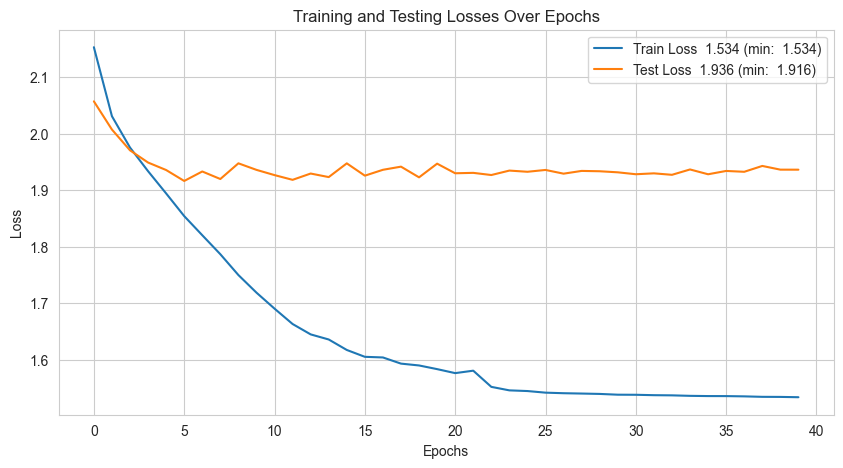

In [12]:
plot_losses(train_losses, val_losses, decimals=3)

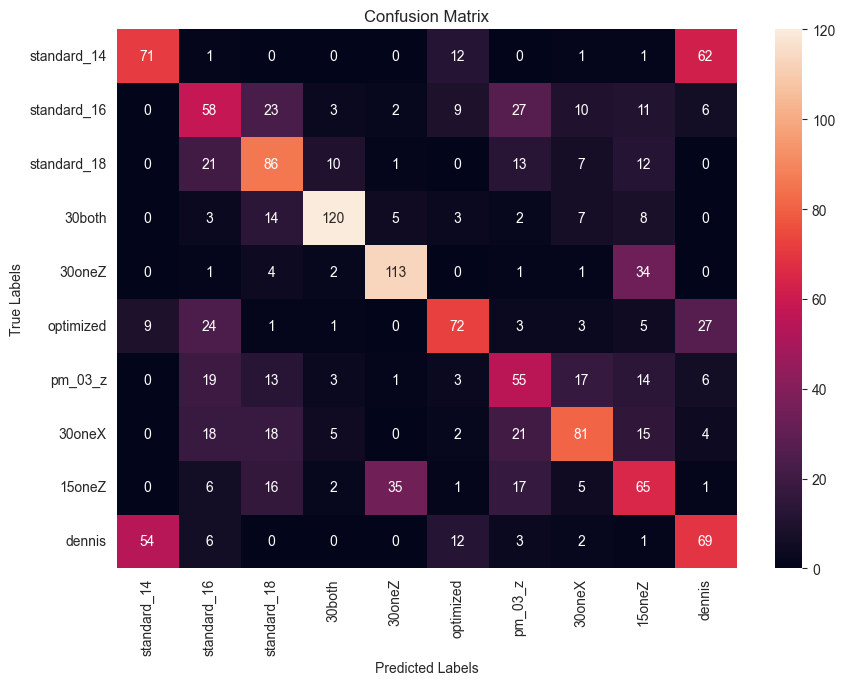

In [13]:
# predictions = model(X_torch.to(device))
# predictions
_, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_test, 1)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
def criterion_correct(predictions, labels):
    _, predicted_labels = torch.max(predictions, 1)
    _, true_class_labels = torch.max(labels, 1)
    # print(predicted_labels)
    # print(y_torch)
    correct_predictions = torch.sum(predicted_labels == true_class_labels).item()
    return correct_predictions


correct_predictions, total = correct_number_test(model, test_loader, criterion_correct)
print(f"Number of correct predictions (test): {correct_predictions}/{total}")

correct_predictions, total = correct_number_test(model, val_loader, criterion_correct)
print(f"Number of correct predictions (val): {correct_predictions}/{total}")

Number of correct predictions (test): 790/1500
Number of correct predictions (val): 788/1500


Creating the least of the weights in 2D as a basis

In [15]:
def build_weights(weights, ls, ps, l1, l2, p1, p2):
    weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
    for l, p, weight in zip(ls, ps, weights):
        weights_ar[l - l1, p - p1] = weight
    return weights_ar

# getting the dimensions
filename = f'..\\{folder}\\data_{knots[0]}_spectr.csv'
with open(filename, 'r') as file:
    reader = csv.reader(file)
    row = next(iter(reader))
    data_list = json.loads(row[0])
    # Convert the list back to a NumPy array if needed
    # print(data_list)
    # data_array = np.array(data_list)
    data_array = data_list

    l1, l2 = data_array[0], data_array[1]
    p1, p2 = data_array[2], data_array[3]
print(l1, l2, p1, p2)

values_basis = []
for knot in knots:
# for knot in ['6foil']:
    print(knot)
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:

        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        values = build_weights(weights, ls, ps, l1, l2, p1, p2)
        values = values / np.sqrt(np.sum(np.abs(values) ** 2))
        values_basis.append(values)
        # plt.imshow(np.abs(values).T[::-1])
        # plt.colorbar()
        # plt.show()

print(len(values_basis), values_basis[0].shape)

-6 6 0 6
standard_14
standard_16
standard_18
30both
30oneZ
optimized
pm_03_z
30oneX
15oneZ
dennis
10 (13, 7)


In [ ]:
# Function to calculate MSE
def calculate_mse(array1, array2):
    return ((np.abs(array1) - np.abs(array2)) ** 2).mean()

closest_basis_knots = []
true_labels = []
for knot in knots:
    closest_basis_knot = []
    true_label = []
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            true_label.append(knot_types[knot])
            data_array = json.loads(row[0])

            # indx = data_array[4]
            # field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            # plt.imshow(np.abs(field ))
            # plt.show()

            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))
            mse_scores = [calculate_mse(moments, values) for values in values_basis]
            closest_basis_knot.append(np.argmin(mse_scores))
            # plt.imshow(np.abs(moments))
            # plt.colorbar()
            # plt.show()
    true_labels.append(true_label)
    closest_basis_knots.append(closest_basis_knot)

# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:
predicted_labels_spec_np = np.array(closest_basis_knots).reshape(-1)
true_labels_spec_np = np.array(true_labels).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# def build_weights(weights, ls, ps, l1, l2, p1, p2):
#     weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
#     for l, p, weight in zip(ls, ps, weights):
#         weights_ar[l - l1, p - p1] = weight
#     return weights_ar
#
# # getting the dimensions
# filename = f'..\\{folder}\\data_{knots[0]}_spectr.csv'
# with open(filename, 'r') as file:
#     reader = csv.reader(file)
#     row = next(iter(reader))
#     data_list = json.loads(row[0])
#     # Convert the list back to a NumPy array if needed
#     # print(data_list)
#     # data_array = np.array(data_list)
#     data_array = data_list
#
#     l1, l2 = data_array[0], data_array[1]
#     p1, p2 = data_array[2], data_array[3]
# print(l1, l2, p1, p2)

knots_basis = []
knots_basis_dots = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\data_basis\\data_{knot}.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            data_array = np.array(data_list)
            points_list = data_array[2:]

            Nx, Ny, Nz = data_array[1]
            if desired_res != (Nx, Ny, Nz):
                scale_x = desired_res[0] / Nx
                scale_y = desired_res[1] / Ny
                scale_z = desired_res[2] / Nz
                points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            knots_basis_dots.append(points_list)
            # Initialize a 3D array with zeros
            dots_3d = np.zeros(desired_res, dtype=int)
            # Set the specified coordinates to 1
            for x, y, z in points_list:
                try: dots_3d[x, y, z] = 1
                except IndexError: continue
            knots_basis.append(dots_3d)

print(len(knots_basis), knots_basis[0].shape)
print(len(knots_basis_dots), knots_basis_dots[0].shape,knots_basis_dots[0][0])
print(knots_basis_dots[0].shape, knots_basis_dots[3].shape)

In [ ]:
# Function to calculate MSE
def calculate_mse_knot(array1, array2):
    return ((array1 - array2) ** 2).mean()

def calculate_mse_knot_dots(array1, dots):
    # loss = -np.sum([np.array(array1)[np.array(dot)] for dot in dots])
    loss = -np.sum([array1[tuple(dot)] for dot in dots])

    return loss

closest_knots = []
closest_knots_dots = []
true_knots = []
j = -1
for i, x in enumerate(X_torch):
    j += 1
    true_knots.append(torch.argmax(y_torch[i]).item())

    mse_scores = [calculate_mse_knot(x[0], knot_) for knot_ in knots_basis]
    closest_knots.append(np.argmin(mse_scores))

    mse_scores_dots = [calculate_mse_knot_dots(x[0], dots_) for dots_ in knots_basis_dots]
    # print(mse_scores_dots)
    # min_indices = np.where(mse_scores_dots == np.min(mse_scores_dots))[0]
    # if len(min_indices) > 1:
    #     result = 0
    # else:
    #     result = min_indices[0]
    closest_knots_dots.append(np.argmin(mse_scores_dots))
    # plt.imshow(knots_basis[j][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # plt.imshow(x[0][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # break


# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:

predicted_labels_spec_np = np.array(closest_knots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

predicted_labels_spec_np = np.array(closest_knots_dots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:


X_list_sp = []
Y_list_sp = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:
        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        for row in reader:
                # Deserialize the JSON string back to a list
                data_list = json.loads(row[0])
                # Convert the list back to a NumPy array if needed
                # print(data_list)
                # data_array = np.array(data_list)
                data_array = data_list

                l1, l2 = data_array[0], data_array[1]
                p1, p2 = data_array[2], data_array[3]

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            # print(data_list)
            # data_array = np.array(data_list)
            data_array = data_list

            l1, l2 = data_array[0], data_array[1]
            p1, p2 = data_array[2], data_array[3]
            indx = data_array[4]
            field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            plt.imshow(np.abs(field ))
            plt.show()

            # print(f'l1, l2, p1, p2: {l1}, {l2}, {p1}, {p2} ({(l2 - l1 + 1) * (p2 - p1 + 1)})')
            # moments = np.array(data_array[4:]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            # plt.imshow(np.abs(moments).T[::-1, :])
            # plt.show()
            values = build_weights(weights, ls, ps, l1, l2, p1, p2)
            print(f"{knot}")
            plt.imshow(np.abs(values))
            plt.colorbar()
            plt.show()
            plt.imshow(np.abs(moments))
            plt.colorbar()
            plt.show()
            # plt.imshow(np.real(moments).T[::-1, :])
            # plt.show()
            print(moments)
            break
            # continue
            # points_list = data_array[2:]
            # Nx, Ny, Nz = data_array[1]
            # if desired_res != (Nx, Ny, Nz):
            #     scale_x = desired_res[0] / Nx
            #     scale_y = desired_res[1] / Ny
            #     scale_z = desired_res[2] / Nz
            #     points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            # # Initialize a 3D array with zeros
            # dots_3d = np.zeros(desired_res, dtype=int)
            # # Set the specified coordinates to 1
            # for x, y, z in points_list:
            #     try: dots_3d[x, y, z] = 1
            #     except IndexError: continue
            # X_list.append(dots_3d)
            # # X_list.append(data_array)
            # Y_list.append(knot_types[knot])
    break

In [ ]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
# X_torch = torch.tensor(X_np).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)
X_train, X_val_test, y_train, y_val_test = train_test_split(X_torch, y_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)